In [5]:
from ultralytics import YOLO
from pydantic import BaseModel
import cv2
import csv
import numpy as np
from scipy.signal import savgol_filter
import moviepy.editor as mpy
import glob as glob
import os
import torch

# identify all videos in all folders
alldatafol = './input_videodata/'
allvids = glob.glob(alldatafol + '*.mp4')+glob.glob(alldatafol + '*.avi')+glob.glob(alldatafol + '*.mov')
print(allvids)

# output folder
outputfol = './output/'

['./input_videodata\\TestVideo.mp4']


In [7]:
class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

get_keypoint = GetKeypoint()

# Define skeleton connections
skeleton = [
    (get_keypoint.LEFT_SHOULDER, get_keypoint.RIGHT_SHOULDER),
    (get_keypoint.LEFT_SHOULDER, get_keypoint.LEFT_ELBOW),
    (get_keypoint.RIGHT_SHOULDER, get_keypoint.RIGHT_ELBOW),
    (get_keypoint.LEFT_ELBOW, get_keypoint.LEFT_WRIST),
    (get_keypoint.RIGHT_ELBOW, get_keypoint.RIGHT_WRIST),
    (get_keypoint.LEFT_SHOULDER, get_keypoint.LEFT_HIP),
    (get_keypoint.RIGHT_SHOULDER, get_keypoint.RIGHT_HIP),
    (get_keypoint.LEFT_HIP, get_keypoint.RIGHT_HIP),
    (get_keypoint.LEFT_HIP, get_keypoint.LEFT_KNEE),
    (get_keypoint.RIGHT_HIP, get_keypoint.RIGHT_KNEE),
    (get_keypoint.LEFT_KNEE, get_keypoint.LEFT_ANKLE),
    (get_keypoint.RIGHT_KNEE, get_keypoint.RIGHT_ANKLE),
]

# Load the model
model = YOLO('./yolo_models/yolov8x-pose-p6.pt')

In [152]:
for vid in allvids:
    # identify all videos in folder, either avi or mp4
    vidlocname = os.path.basename(vid)
    # remove the last 4 characters
    vidlocname = vidlocname[:-4]
    # Open the video
    cap = cv2.VideoCapture(vid)
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))/2) #were making the video half the size
    height = int(int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))/2) #were making the video half the size
    # Define the output video writer
    output_path = outputfol + '/' + vidlocname + '_annotated_layer1.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(width), int(height)))
    # Prepare CSV file
    csv_path = outputfol + '/' + vidlocname + '_keypoints_data_layer1.csv'
    csv_file = open(csv_path, 'w', newline='')
    csv_writer = csv.writer(csv_file)
    # Write header
    header = ['frame', 'person', 'keypoint', 'x', 'y']
    csv_writer.writerow(header)
    frame_count = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        # Run YOLOv8 inference on the frame
        results = model(frame)
        # Visualize the results on the frame
        annotated_frame = results[0].plot()
        # write empty rows if no person is detected
        if len(results[0].keypoints.xy) == 0:
            csv_writer.writerow([frame_count, None, None, None, None])
            annotated_frame = frame
        # only do this if a person is detected
        if len(results[0].keypoints.xy) > 0:
            # Process the results
            for person_idx, person_keypoints in enumerate(results[0].keypoints.xy):
                #only process the first two people
                if person_idx == 0 or person_idx == 1:
                    for keypoint_idx, keypoint in enumerate(person_keypoints):
                        x, y = keypoint
                        # Write to CSV
                        csv_writer.writerow([frame_count, person_idx, keypoint_idx, x.item(), y.item()])       
                        # Draw keypoint on the frame
                        cv2.circle(annotated_frame, (int(x), int(y)), 5, (0, 255, 0), -1)
                    # Draw skeleton
                    for connection in skeleton:
                        if connection[0] < len(person_keypoints) and connection[1] < len(person_keypoints):
                            start_point = tuple(map(int, person_keypoints[connection[0]]))
                            end_point = tuple(map(int, person_keypoints[connection[1]]))
                            if all(start_point) and all(end_point):  # Check if both points are valid
                                cv2.line(annotated_frame, start_point, end_point, (255, 0, 0), 2)
        # Write the frame to the output video
                                # downsize the video by a half
        annotated_frame = cv2.resize(annotated_frame, (width, height))
        out.write(annotated_frame)
        frame_count += 1

    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    csv_file.close()

    print(f"Output video saved as {output_path}")
    print(f"Keypoints data saved as {csv_path}")




0: 768x1280 2 persons, 286.2ms
Speed: 10.0ms preprocess, 286.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 3 persons, 27.0ms
Speed: 6.0ms preprocess, 27.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 2 persons, 26.0ms
Speed: 5.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 2 persons, 26.0ms
Speed: 6.0ms preprocess, 26.0ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 2 persons, 26.0ms
Speed: 5.0ms preprocess, 26.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 3 persons, 27.0ms
Speed: 8.0ms preprocess, 27.0ms inference, 4.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 2 persons, 25.0ms
Speed: 6.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 2 persons, 24.0ms
Speed: 7.0ms preprocess, 24.0ms inference, 1.0ms postprocess pe

Now we have the raw data produced. Below, we load the csv and print a few lines. We will have frame numbers, the particular keypoints, for each person and the x and y coordinates. We will now process the interpersonal distance between the two persons ID0 and ID1 (which will correspond to the same persons if the two persons are in frame for the entire video). 

In [153]:
import pandas as pd

ts = pd.read_csv(csv_path)
ts.head()


,frame,person,keypoint,x,y
0,0,0,0,1214.451050,668.855347
1,0,0,1,1241.696045,703.337097
2,0,0,2,0.000000,0.000000
3,0,0,3,1339.230835,815.410278
4,0,0,4,0.000000,0.000000


In [154]:
for vids in allvids:
    vidname = os.path.basename(vids)
    vidname = vidname[:-4]
    # Load the CSV file
    ts = pd.read_csv(outputfol + '/' + vidname + '_keypoints_data_layer1.csv')
    bb_data = pd.DataFrame(columns=['frame', 'person', 'x_min', 'x_max', 'y_min', 'y_max', 'centroid_x', 'centroid_y', 'com_x', 'com_y'])
    # for each frame we have two persons, so lets fill two rows with frame1, person 0 and frame1, person 1
    for frame in ts['frame'].unique():
        bb_data.loc[2*frame, ('frame', 'person')] = [frame, 0]
        bb_data.loc[2*frame + 1, ('frame', 'person')] = [frame, 1]
      
    # Get the bounding box for each person in each frame
    for frame in bb_data['frame'].unique():
        for person in range(2):
            person_data = ts[(ts['frame'] == frame) & (ts['person'] == person)]   
            # exclude lower body
            person_data = person_data[person_data['keypoint'] < 11]

            x_min = person_data['x'].min()
            x_max = person_data['x'].max()
            y_min = person_data['y'].min()
            y_max = person_data['y'].max()
            centroid_x = (x_min + x_max) / 2
            centroid_y = (y_min + y_max) / 2
            # also add the centroid of all keypoints
            com_x = person_data['x'].mean()
            com_y = person_data['y'].mean()
            # fill the bbdata at this frame and person loc
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'x_min'] = x_min
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'x_max'] = x_max
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'y_min'] = y_min
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'y_max'] = y_max
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'centroid_x'] = centroid_x
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'centroid_y'] = centroid_y
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'com_x'] = com_x
            bb_data.loc[(bb_data['frame'] == frame) & (bb_data['person'] == person), 'com_y'] = com_y
                       

# save the bounding box data
bb_data.to_csv(outputfol + '/' + vidname + '_bounding_box_data_layer1.csv', index=False)
# Save the bounding box data to a CSV file     
bb_data.head()

,frame,person,x_min,x_max,y_min,y_max,centroid_x,centroid_y,com_x,com_y
0,0,0,0.0,1487.703125,0.0,914.364075,743.851562,457.182037,936.936113,557.126604
1,0,1,0.0,410.124115,0.0,654.685181,205.062057,327.34259,255.273926,390.594403
2,1,0,0.0,1489.873657,0.0,911.778809,744.936829,455.889404,937.651045,556.381797
3,1,1,0.0,409.824036,0.0,654.684998,204.912018,327.342499,257.967192,390.225593
4,2,0,0.0,1490.803711,0.0,911.613281,745.401855,455.806641,937.999495,556.126262


# Interpersonal distance
So now we have bounding box information for the video(s), as well as the centroids of the bounding boxes. What we will do now is calculate the euclidean distance of the centroids to get a sense of how close person 1 and 2's body are with respect to each other.

In [155]:
from scipy.signal import savgol_filter

for vids in allvids:
    vidname = os.path.basename(vids)
    vidname = vidname[:-4]
    # Load the CSV file
    bb_data = pd.read_csv(outputfol + '/' + vidname + '_bounding_box_data_layer1.csv')
    frames = range(1, bb_data['frame'].max() + 1)
    # new df with rows for each frame
    distance_data = pd.DataFrame(columns=['frame', 'distance'])
    for frame in frames:
        distance_data.loc[frame] = [frame, None]

    for frame in frames:
        frame_data = bb_data[bb_data['frame'] == frame]
        #print(frame_data)
        # Calculate the distance between the centroids of the bounding boxes
        if len(frame_data) == 2:
            centroid1 = frame_data[frame_data['person'] == 0][['centroid_x', 'centroid_y']].values[0]
            centroid2 = frame_data[frame_data['person'] == 1][['centroid_x', 'centroid_y']].values[0]
            #take the euclidean L2
            distance = ((centroid1[0]-centroid2[0])**2+(centroid1[1]-centroid2[1])**2)**0.5
            # Fill the distance data
            distance_data.loc[distance_data['frame'] == frame, 'distance'] = distance
    # Save the distance data to a CSV file
        # lets interpolate None values linearly
    distance_data['distance'] = distance_data['distance'].interpolate()

    # lets mooth the distance a bit
    distance_data['distance_smooth'] = savgol_filter(distance_data['distance'], 15, 2)
    distance_data.to_csv(outputfol + '/' + vidname + '_distance_data_layer1.csv', index=False)

# check for nan or None values
print(distance_data.isnull().sum())

distance_data.head()

frame              0
distance           0
distance_smooth    0
dtype: int64


,frame,distance,distance_smooth
1,1.0,555.113595,555.280682
2,2.0,554.860639,554.023880
3,3.0,553.477376,552.784713
4,4.0,550.661830,551.563183
5,5.0,550.970728,550.359290


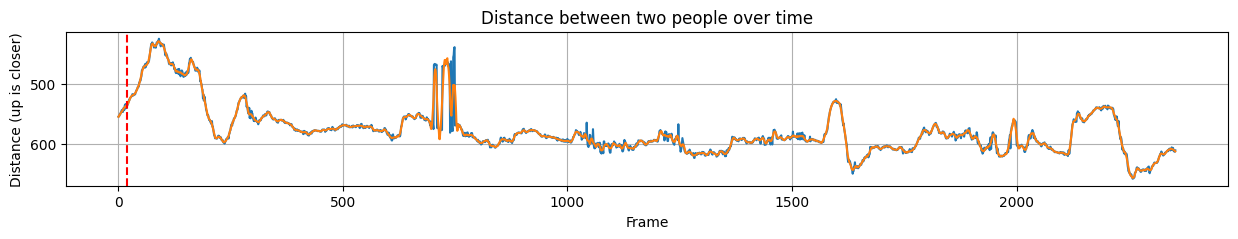

In [156]:
# plot the distance
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import cv2

# Load the CSV file
distance_data = pd.read_csv(outputfol + '/' + vidname + '_distance_data_layer1.csv')

# make a function out of this
def plot_distance(distance_data, frame, show = False):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=distance_data, x='frame', y='distance')
    sns.lineplot(data=distance_data, x='frame', y='distance_smooth')
    plt.xlabel('Frame')
    plt.ylabel('Distance')
    plt.title('Distance between two people over time')
    plt.grid()
    plt.axvline(x=frame, color='r', linestyle='--')
    # flip the y axis (up is closer)
    plt.gca().invert_yaxis()
    # add a note on the y label
    plt.ylabel('Distance (up is closer)')
    # make the image much broader than taller
    plt.gcf().set_size_inches(15, 2)
    if show == True:
        plt.show()
    # render plot immediately to an imgae
    imageplot = plt.gcf()
    plt.close()
    return imageplot

test = plot_distance(distance_data, 20, show = True)


In [157]:
import tqdm

#check all videos with layer 1
allvidsnew = glob.glob(outputfol + '*_layer1.mp4')

# make an annimation
for vids, vidsnew in zip(allvids, allvidsnew):
    vidname = os.path.basename(vids)
    vidname = vidname[:-4]
    # Load the CSV file
    distance_data = pd.read_csv(outputfol + '/' + vidname + '_distance_data_layer1.csv')
    # load the video file in opencv
    cap = cv2.VideoCapture(vidsnew)
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Define the output video writer
    output_path = outputfol + '/' + vidname + '_distance_layer2.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # loop over the frames with tqdm processbar
    frame_count = 0
    for _ in tqdm.tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame
        success, frame = cap.read()
        if not success:
            break
        # plot the distance
        plot = plot_distance(distance_data, frame_count)
        # save the plot to a temp file in the output folder
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False, dir=outputfol) as f:        
            plot.savefig(f.name)
            plot_img = cv2.imread(f.name)
            # resize the plot image to the size of the frame
            plot_img = cv2.resize(plot_img, (width, int(height/3)))
            # add the plot image to the frame
            frame[2*int(height/3):, :, :] = plot_img
            # write the frame to the output video
            # downsize the video by a half
            out.write(frame)
                 
        frame_count += 1
    # Release everything
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Output video saved as {output_path}")
    # delete all temp files
    for file in glob.glob(outputfol + '/*.png'):
        os.remove(file)

  0%|          | 0/2354 [00:00<?, ?it/s]

100%|██████████| 2354/2354 [02:29<00:00, 15.73it/s]


Output video saved as ./output//TestVideo_distance_layer2.mp4
